In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Dessinez vos applications - Projet Python ENSAE 2A

Par Solène Cochennec et Pierre Delanoue 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Mise à disposition des données 

In [3]:
import numpy as np
import cv2
from PIL import Image

from glob import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt

### Chargement des données 

In [4]:
imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   
    images_base_vide+=[im]
    label_nom_vide+=[file.split('\\')[1].split('_')[0]]   
images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

In [5]:
def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
   

In [6]:
from sklearn.model_selection import train_test_split


In [7]:
ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

In [8]:
X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

In [9]:
label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

In [10]:
def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            deg_rot=(k%2)*(((k+1)//2))*5+(1-k%2)*(((k+1)//2)*(-5))
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), deg_rot, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
  

### Train et Test Classiques

In [11]:
num_aug_classique=7

In [12]:
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique,data_aug=num_aug_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

### Train et Test Progressifs

In [13]:
catégories= ['Deezer','Facebook','Messenger','Tinder']

In [14]:
X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('\\')[1].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('\\')[1].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)

In [15]:
num_aug_progressif=7

In [16]:
Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif,data_aug=num_aug_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

### Le jeu de données qu'on utilise ici

In [17]:
Train_dic=Train_Classique
Test_dic=Test_Classique

In [18]:
# Nombre pixel coté
img_size = Train_dic['image'].shape[1]

# Nombre de pixel au total
img_size_flat = Train_dic['data'].shape[1]

# Nombre de pixel longeur et largeur 
img_shape = Train_dic['image'].shape[1:]

# Nombre de classes (si on ajoute de nouveaux logos)
num_classes = 4 

## Modèles avec Tensorflow

In [19]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random

### Informations utiles 

### Fonction que l'on va utiliser plusieurs fois 

In [20]:
def plot_image(image):
    
    plt.imshow(image.reshape(img_shape), interpolation='nearest',cmap='binary')
    plt.show()

In [21]:
def plot_9_images(images, cls_vrai, cls_pred=None):
    assert len(images) == len(cls_vrai) == 9

    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_vrai[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_vrai[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

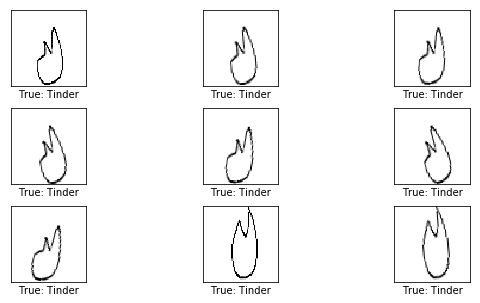

In [22]:
images = Train_dic['image'][0:9]
cls_vrai = [num_to_label[i] for i in Train_dic['label_num'][0:9]]


plot_9_images(images=images, cls_vrai=cls_vrai)

In [23]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [24]:
def exemples_erreurs():
    
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = Test_dic['data'][incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_vrai = Test_dic['label_num'][incorrect]
    
    plot_9_images(images=images[0:9],
                cls_vrai=[num_to_label[i] for i in cls_vrai[0:9]],
                cls_pred=[num_to_label[i] for i in cls_pred[0:9]])

In [25]:
def matrice_de_confusion():

    cls_true = Test_dic['label_num']
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Prédite')
    plt.ylabel('Vraie')
    
    plt.show()

In [26]:
def print_accuracy():

    acc = session.run(accuracy, feed_dict=feed_dict_test)

    print("Accuracy sur Test set: {0:.1%}".format(acc))

### Modèle linéaire simple

### MLS - Construction des variables 

In [27]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [28]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [29]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [30]:
poids = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [31]:
biases = tf.Variable(tf.zeros([num_classes]))

In [32]:
logits = tf.matmul(x, poids) + biases

In [33]:
y_pred = tf.nn.softmax(logits)

In [34]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [35]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [36]:
cost = tf.reduce_mean(cross_entropy)

In [37]:
optimizer_mls = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [38]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [39]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
session = tf.Session()

In [41]:
session.run(tf.global_variables_initializer())

In [42]:
batch_size = 100

In [43]:
def optimize_mls(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer_mls, feed_dict=feed_dict_train)

In [44]:
def visualisation_poids():
    
    w = session.run(poids)
 
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(2, 2)


    for i, ax in enumerate(axes.flat):

        image = w[:, i].reshape(img_shape)
        ax.set_xlabel("Poids: {0}".format(num_to_label[i]))
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [45]:
feed_dict_test = {x: Test_dic['data'], y_true: Test_dic['label_OneHot'], y_true_cls: Test_dic['label_num']}

In [46]:
print_accuracy()

Accuracy sur Test set: 20.8%


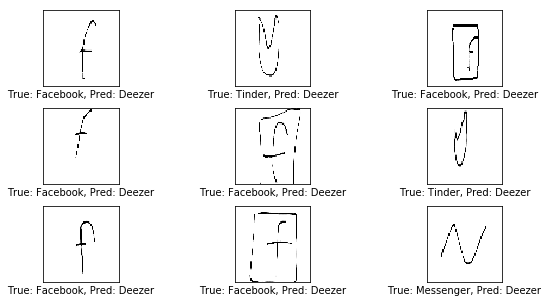

In [47]:
exemples_erreurs()

In [48]:
optimize_mls(num_iterations=1)

In [49]:
print_accuracy()

Accuracy sur Test set: 21.5%


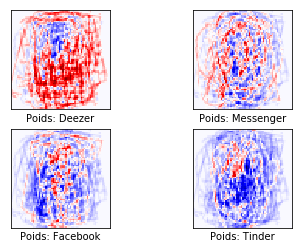

In [50]:
visualisation_poids()

In [52]:
optimize_mls(num_iterations=9)

In [53]:
print_accuracy()

Accuracy sur Test set: 48.8%


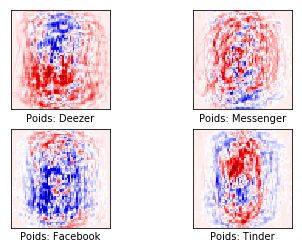

In [54]:
visualisation_poids()

In [55]:
optimize_mls(num_iterations=990)

In [56]:
print_accuracy()

Accuracy sur Test set: 41.9%


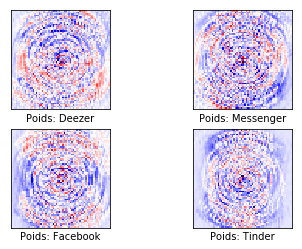

In [57]:
visualisation_poids()

[[46  3 10  4]
 [29 15 29  4]
 [20 10 45  6]
 [14  4 43 21]]


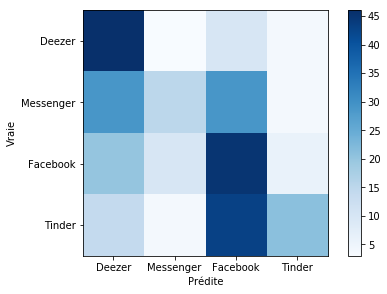

In [58]:
matrice_de_confusion()

In [59]:
session.close()

### Réseau neuronal convolutif  (Convolutional Neural Network)

In [60]:
tf.reset_default_graph()

In [61]:
# Premier convolutional Layer.
filter_size1 = 5          # Filtre de 5 x 5 pixels.
num_filters1 = 16         # Il y a ici 16 filtres.

# Deuxième convolutional Layer
filter_size2 = 5          # Filtre de 5 x 5 pixels.
num_filters2 = 36         # Il y a ici 36 filtres .

# Couche fully connected 
fc_size = 128             # Nombre de neuronnes dans la dernière couche 

# Noir et blanc ? 1 si oui 
num_channels = 1

In [62]:
def crea_poids(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def nouveau_biais(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [63]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = crea_poids(shape=shape)

    biases = nouveau_biais(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:

        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [64]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [65]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 

  
    weights = crea_poids(shape=[num_inputs, num_outputs])
    biases = nouveau_biais(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [66]:
def plot_conv_weights(weights, input_channel=0):

    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):

        if i<num_filters:

            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [67]:
def plot_conv_layer(layer, image):

    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)


    for i, ax in enumerate(axes.flat):

        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

#### CNN - Construction des varaibles 

In [68]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [69]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [70]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [71]:
y_true_cls = tf.argmax(y_true, axis=1)

In [72]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [73]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [74]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [75]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [76]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [77]:
y_pred = tf.nn.softmax(layer_fc2)

In [78]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [79]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [80]:
cost = tf.reduce_mean(cross_entropy)

In [81]:
optimizer_cnn = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [82]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [83]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [84]:
session = tf.Session()

In [85]:
session.run(tf.global_variables_initializer())

In [86]:
train_batch_size = 64

In [87]:
total_iterations = 0
batch_size=100

def optimize_cnn(num_iterations):
    
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)


        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer_cnn, feed_dict=feed_dict_train)

        if i % 100 == 0:

            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Nombre d'Optimisation : {0:>6}, Accuracy sur Train set: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time

    print("Temps d'usage: " + str(timedelta(seconds=int(round(time_dif)))))

#### CNN - Résultats

In [88]:
feed_dict_test = {x: Test_dic['data'],
                  y_true: Test_dic['label_OneHot'],
                  y_true_cls: Test_dic['label_num']}

In [89]:
print_accuracy()

Accuracy sur Test set: 28.7%


In [90]:
optimize_cnn(num_iterations=1)

Nombre d'Optimisation :      1, Accuracy sur Train set:  28.0%
Temps d'usage: 0:00:02


In [91]:
print_accuracy()

Accuracy sur Test set: 29.7%


In [92]:
for i in range(10): 
    optimize_cnn(num_iterations=100) 
    print_accuracy()

Nombre d'Optimisation :    101, Accuracy sur Train set:  76.0%
Temps d'usage: 0:01:59
Accuracy sur Test set: 66.0%
Nombre d'Optimisation :    201, Accuracy sur Train set:  84.0%
Temps d'usage: 0:01:54
Accuracy sur Test set: 74.6%
Nombre d'Optimisation :    301, Accuracy sur Train set:  91.0%
Temps d'usage: 0:01:59
Accuracy sur Test set: 77.2%
Nombre d'Optimisation :    401, Accuracy sur Train set:  95.0%
Temps d'usage: 0:01:51
Accuracy sur Test set: 80.2%
Nombre d'Optimisation :    501, Accuracy sur Train set:  96.0%
Temps d'usage: 0:01:56
Accuracy sur Test set: 82.8%
Nombre d'Optimisation :    601, Accuracy sur Train set:  99.0%
Temps d'usage: 0:01:55
Accuracy sur Test set: 84.5%
Nombre d'Optimisation :    701, Accuracy sur Train set:  96.0%
Temps d'usage: 0:01:57
Accuracy sur Test set: 84.8%
Nombre d'Optimisation :    801, Accuracy sur Train set: 100.0%
Temps d'usage: 0:01:57
Accuracy sur Test set: 85.1%
Nombre d'Optimisation :    901, Accuracy sur Train set:  99.0%
Temps d'usage: 0:

[[52  4  4  3]
 [ 0 72  2  3]
 [ 6  5 62  8]
 [ 3  2  2 75]]


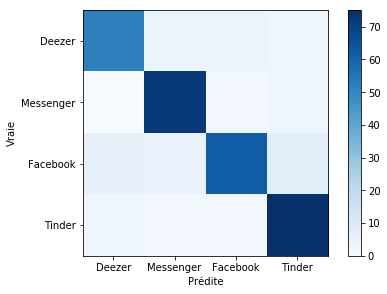

In [93]:
matrice_de_confusion()

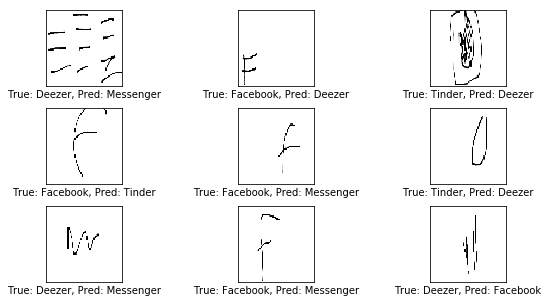

In [94]:
exemples_erreurs()


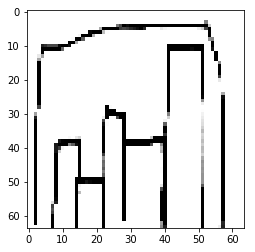

In [95]:
image1 = Test_dic['data'][24]
plot_image(image1)

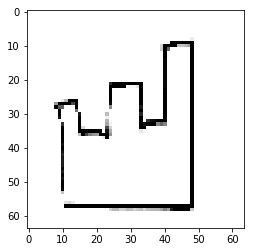

In [96]:
image2 = Test_dic['data'][19]
plot_image(image2)

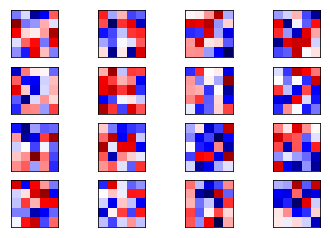

In [97]:
plot_conv_weights(weights=weights_conv1)

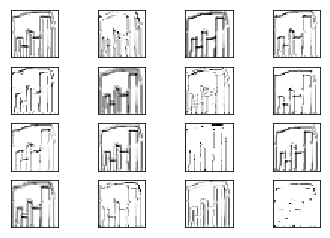

In [98]:
plot_conv_layer(layer=layer_conv1, image=image1)

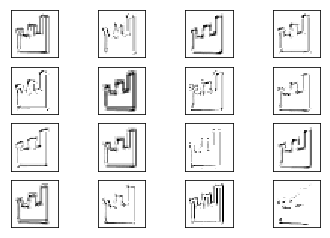

In [99]:
plot_conv_layer(layer=layer_conv1, image=image2)

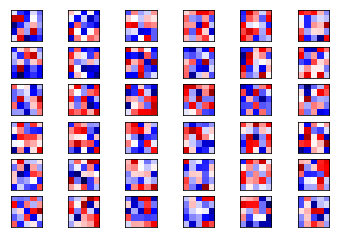

In [100]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

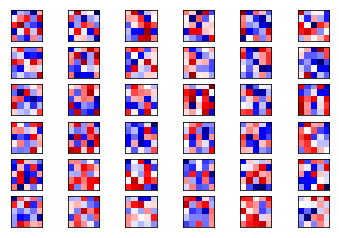

In [101]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

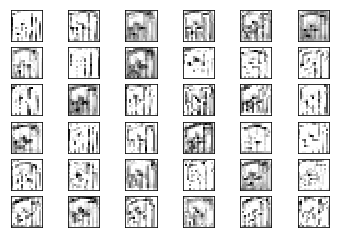

In [102]:
plot_conv_layer(layer=layer_conv2, image=image1)   

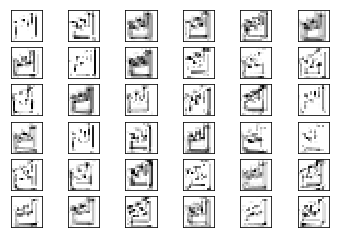

In [103]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [104]:
session.close()